In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from collections import Counter
import cryptoaml.datareader as cdr

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

from skmultiflow.meta import LearnNSE
from skmultiflow.meta import LeverageBagging
from skmultiflow.trees import HoeffdingTree
from sklearn.tree import DecisionTreeClassifier
from skmultiflow.meta import AdaptiveRandomForest
from cryptoaml.models import AdaptiveXGBoostClassifier
from cryptoaml.models import AdaptiveStackedBoostClassifier

from sklearn.exceptions import UndefinedMetricWarning

from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import NeighbourhoodCleaningRule

from cryptoaml.metrics import (
    results_table, 
    plot_metric_dist,
    plot_feature_imp,
    print_model_params, 
    plot_result_matrices,
    display_metrics_stats,
    elliptic_time_indexed_results
)

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

/home/delinvas/anaconda3/envs/btc-classifier/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.



In [2]:
def evaluate_batch_incremental(model, data, t_eval=35):
    
    results = {}
    results_time = []
    true_test = []
    predictions_test = []
    
    for ts in np.arange(data["ts"].min(), data["ts"].max()):
        
        # get training data for the current timestep 
        train_set = data[data["ts"] == ts]
        train_set_X = train_set.iloc[:,:-1]
        train_set_y = train_set["class"].astype(int)      
        
        # partially fit model 
        model.partial_fit(train_set_X.values, train_set_y.values)    

        # get test data for the current timestep + 1 
        test_set = data[data["ts"] == ts + 1]
        test_set_X = test_set.iloc[:,:-1].values
        test_set_y = test_set["class"].values.astype(int)
    
        # predict test data for the current timestep + 1
        try:
            print(ts+1)
            y_pred = model.predict(test_set_X)
        except:
            print('continues')
            continue
        y_pred= [int(i) for i in y_pred]
        
        evaluation_f1 = f1_score(test_set_y, y_pred, average='binary', labels=np.unique(y_pred))
        evaluation_recall = recall_score(test_set_y, y_pred, average='binary', labels=np.unique(y_pred))
        evaluation_precision = precision_score(test_set_y, y_pred, average='binary', labels=np.unique(y_pred))
        evaluation_accuracy = accuracy_score(test_set_y, y_pred, normalize=True)
        
        # (evaluation set)
        if ts+1 >= t_eval:
            true_test.append(test_set_y)
            predictions_test.append(y_pred)
            label_count = test_set["class"].value_counts().to_dict()
            results_time.append({"timestep": ts + 1, 
                                 "score":evaluation_f1, 
                                 "total_pos_label": label_count.get(0, 0)}) 

            
    test_results = {}
    f1_score_test = f1_score(np.concatenate(true_test, axis=0), 
                        np.concatenate(predictions_test, axis=0), 
                        average='binary')
    recall_score_test = recall_score(np.concatenate(true_test, axis=0),   
                                np.concatenate(predictions_test, axis=0), 
                                average='binary')
    precision_score_test = precision_score(np.concatenate(true_test, axis=0),   
                                      np.concatenate(predictions_test, axis=0), 
                                      average='binary')
    accuracy_score_test = accuracy_score(np.concatenate(true_test, axis=0),   
                                    np.concatenate(predictions_test, axis=0), 
                                    normalize=True)
    confusion_matrix_test = confusion_matrix(np.concatenate(true_test, axis=0), 
                                             np.concatenate(predictions_test, axis=0))
    
    test_results["f1"] = round(f1_score_test, 3)   
    test_results["recall"] = round(recall_score_test, 3)   
    test_results["precision"] = round(precision_score_test, 3)   
    test_results["accuracy"] = round(accuracy_score_test, 3)   
    test_results["confusion_matrix"] = confusion_matrix_test  
    
    results["test_results"] = test_results
    results["time_metrics"] = pd.DataFrame(results_time)   

    return results

In [15]:
def evaluate(feature_set, n_eval, N):
    noaa = cdr.get_data("noaa_weather")
    data_eval = noaa.train_test_split(train_size=0.7)["ALL"]

    train_data = data_eval.train_X
    train_data["class"] = data_eval.train_y
    test_data = data_eval.test_X
    test_data["class"] = data_eval.test_y 
    data_eval = train_data.append(test_data, ignore_index=True)
    
    f_set = "noaa"+"_"+feature_set
    experiment_3_results = {}
    experiment_3_results["ARF"] = {}
#     experiment_3_results["AXGBr"] = {}
#     experiment_3_results["AXGBp"] = {}
#     experiment_3_results["ASXGB"] = {}
    experiment_3_results["ARF"][f_set] = {}
#     experiment_3_results["AXGBr"][f_set] = {}
#     experiment_3_results["AXGBp"][f_set] = {}
#     experiment_3_results["ASXGB"][f_set] = {}

#     2. Adapative Random Forest
    print("Evaluating ARF")
    arf = AdaptiveRandomForest(performance_metric="kappa")
    experiment_3_results["ARF"][f_set] = evaluate_batch_incremental(arf, data_eval, n_eval)
    
    # 2. Adapative Extreme Gradient Boosting with Replacement
    # 3. Adapative Extreme Gradient Boosting with Push
    # Adaptive XGBoost classifier parameters
    n_estimators = 30       # Number of members in the ensemble
    learning_rate = 0.3     # Learning rate or eta
    max_depth = 6           # Max depth for each tree in the ensemble
    max_window_size = 1000  # Max window size
    min_window_size = 1     # set to activate the dynamic window strategy
    detect_drift = False    # Enable/disable drift detection

#     print("Evaluating AXGBr")
#     AXGBr = AdaptiveXGBoostClassifier(update_strategy='replace',
#                                       n_estimators=n_estimators,
#                                       learning_rate=learning_rate,
#                                       max_depth=max_depth,
#                                       max_window_size=max_window_size,
#                                       min_window_size=min_window_size,
#                                       detect_drift=detect_drift)
#     experiment_3_results["AXGBr"][f_set] = evaluate_batch_incremental(AXGBr, data_eval, n_eval)

#     print("Evaluating AXGBp")
#     AXGBp = AdaptiveXGBoostClassifier(update_strategy='push',
#                                       n_estimators=n_estimators,
#                                       learning_rate=learning_rate,
#                                       max_depth=max_depth,
#                                       max_window_size=max_window_size,
#                                       min_window_size=min_window_size,
#                                       detect_drift=detect_drift)
#     experiment_3_results["AXGBp"][f_set] = evaluate_batch_incremental(AXGBp, data_eval, n_eval)

    # 4. Proposed Method
    print("Evaluating ASXGB")
#     ASXGB = AdaptiveStackedBoostClassifier(min_window_size=30,
#                                           max_window_size=2000, 
#                                           n_rounds_eval_base_model=1,
#                                           n_base_models=2,
#                                           meta_learner_train_ratio=0.4)
#     ASXGB = AdaptiveStackedBoostClassifier(min_window_size=30,
#                                           max_window_size=1000, 
#                                           n_rounds_eval_base_model=4,
#                                           n_base_models=15,
#                                           meta_learner_train_ratio=0.4)
        
#     experiment_3_results["ASXGB"][f_set] = evaluate_batch_incremental(ASXGB, data_eval, n_eval)
    
    tmp_results = {**experiment_3_results}
    
#     x = tmp_results["ARF"]["noaa_ALL"]["time_metrics"]
#     df = pd.DataFrame() 
#     df["timestep"] = x["timestep"].groupby(x.index // N).max()
#     df["score"] = x["score"].groupby(x.index // N).mean()
#     df["total_pos_label"] = x["total_pos_label"].groupby(x.index // N).sum()
#     tmp_results["ARF"]["noaa_ALL"]["time_metrics"] = df
    
    x = tmp_results["ARF"]["noaa_ALL"]["time_metrics"]
    df = pd.DataFrame() 
    df["timestep"] = x["timestep"].groupby(x.index // N).max()
    df["score"] = x["score"].groupby(x.index // N).mean()
    df["total_pos_label"] = x["total_pos_label"].groupby(x.index // N).sum()
    tmp_results["ARF"]["noaa_ALL"]["time_metrics"] = df

#     x = tmp_results["AXGBp"]["noaa_ALL"]["time_metrics"]
#     df = pd.DataFrame() 
#     df["timestep"] = x["timestep"].groupby(x.index // N).max()
#     df["score"] = x["score"].groupby(x.index // N).mean()
#     df["total_pos_label"] = x["total_pos_label"].groupby(x.index // N).sum()
#     tmp_results["AXGBp"]["noaa_ALL"]["time_metrics"] = df

#     x = tmp_results["ASXGB"]["noaa_ALL"]["time_metrics"]
#     df = pd.DataFrame() 
#     df["timestep"] = x["timestep"].groupby(x.index // N).max()
#     df["score"] = x["score"].groupby(x.index // N).mean()
#     df["total_pos_label"] = x["total_pos_label"].groupby(x.index // N).sum()
#     tmp_results["ASXGB"]["noaa_ALL"]["time_metrics"] = df
    
    elliptic_time_indexed_results(experiment_3_results)
    print(experiment_3_results)

Evaluating ARF
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274

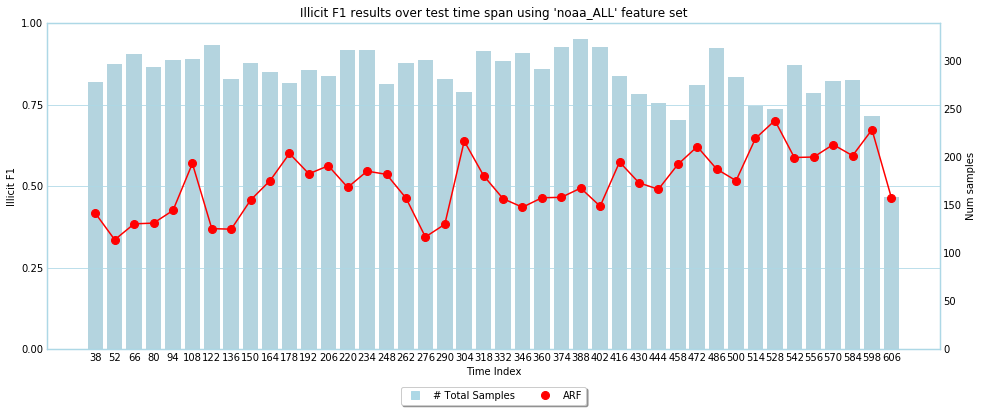

{'ARF': {'noaa_ALL': {'test_results': {'f1': 0.589, 'recall': 0.501, 'precision': 0.713, 'accuracy': 0.78, 'confusion_matrix': array([[10847,  1108],
       [ 2735,  2749]])}, 'time_metrics':     timestep     score  total_pos_label
0         38  0.416877              278
1         52  0.335530              297
2         66  0.384244              307
3         80  0.386589              293
4         94  0.425335              301
5        108  0.569394              302
6        122  0.369579              316
7        136  0.367941              281
8        150  0.457356              298
9        164  0.516733              288
10       178  0.600053              277
11       192  0.537715              290
12       206  0.562384              284
13       220  0.496020              311
14       234  0.545926              311
15       248  0.535923              276
16       262  0.463329              298
17       276  0.344063              301
18       290  0.382938              281
19      

In [16]:
evaluate("ALL", 25, 14)

In [13]:
print(experiment_3_results)

NameError: name 'experiment_3_results' is not defined

In [14]:
print(x)

NameError: name 'x' is not defined

In [84]:
import json
import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO
import pandas as pd

    
TESTDATA = StringIO('''
timestep     score  total_pos_label
38  0.416877              278
52  0.335530              297
66  0.384244              307
80  0.386589              293
94  0.425335              301
108  0.569394              302
122  0.369579              316
136  0.367941              281
150  0.457356              298
164  0.516733              288
178  0.600053              277
192  0.537715              290
206  0.562384              284
220  0.496020              311
234  0.545926              311
248  0.535923              276
262  0.463329              298
276  0.344063              301
290  0.382938              281
304  0.637858              267
318  0.531938              310
332  0.461407              300
346  0.435246              308
360  0.464197              291
374  0.465605              314
388  0.493852              323
402  0.438315              314
416  0.573914              284
430  0.510090              265
444  0.490309              256
458  0.566265              238
472  0.621046              275
486  0.552303              313
500  0.516652              283
514  0.646244              253
528  0.701102              250
542  0.587676              296
556  0.589181              266
570  0.627334              279
584  0.593312              280
598  0.672888              242
606  0.464211              158
''')

test = {}


x = pd.read_csv(TESTDATA, delim_whitespace=True).copy()
test["ARF"] = {}
test["ARF"]["noaa_ALL"] = {}
test["ARF"]["noaa_ALL"]["test_results"] = {}
test["ARF"]["noaa_ALL"]["time_metrics"] = x

TESTDATA = StringIO('''
timestep     score  total_pos_label
38  0.455468              278
52  0.475775              297
66  0.371342              307
80  0.481394              293
94  0.450607              301
108  0.517454              302
122  0.400856              316
136  0.416630              281
150  0.530065              298
164  0.522578              288
178  0.630550              277
192  0.550741              290
206  0.664869              284
220  0.531622              311
234  0.526477              311
248  0.562115              276
262  0.523913              298
276  0.446765              301
290  0.468434              281
304  0.650155              267
318  0.544461              310
332  0.416764              300
346  0.426297              308
360  0.549923              291
374  0.462744              314
388  0.553882              323
402  0.478581              314
416  0.575880              284
430  0.586096              265
444  0.497118              256
458  0.610244              238
472  0.661312              275
486  0.525032              313
500  0.558255              283
514  0.726357              253
528  0.684974              250
542  0.650649              296
556  0.570873              266
570  0.591980              279
584  0.536322              280
598  0.640796              242
606  0.443602              158
''')

x = pd.read_csv(TESTDATA, delim_whitespace=True)
test["AXGBr"] = {}
test["AXGBr"]["noaa_ALL"] = {}
test["AXGBr"]["noaa_ALL"]["test_results"] = {}
test["AXGBr"]["noaa_ALL"]["time_metrics"] = x

TESTDATA = StringIO('''
timestep     score  total_pos_label
38  0.384180              278
52  0.310587              297
66  0.342715              307
80  0.328596              293
94  0.357659              301
108  0.470173              302
123  0.441301              317
137  0.502856              276
151  0.394137              295
166  0.433041              284
180  0.421530              282
196  0.431372              303
211  0.488834              281
225  0.402440              296
239  0.501866              289
253  0.268728              285
267  0.413916              302
281  0.291687              319
295  0.407428              264
309  0.530097              282
323  0.404152              291
337  0.365192              306
351  0.461119              302
367  0.411984              323
381  0.390464              313
395  0.366023              326
409  0.581949              283
423  0.528270              276
437  0.452699              276
451  0.585715              251
465  0.554852              254
479  0.559182              280
494  0.392596              285
508  0.479119              278
522  0.552601              264
536  0.428849              270
550  0.492261              269
564  0.433754              269
578  0.510526              291
592  0.495091              244
606  0.388928              277
''')

x = pd.read_csv(TESTDATA, delim_whitespace=True)
test["ASXGB"] = {}
test["ASXGB"]["noaa_ALL"] = {}
test["ASXGB"]["noaa_ALL"]["test_results"] = {}
test["ASXGB"]["noaa_ALL"]["time_metrics"] = x

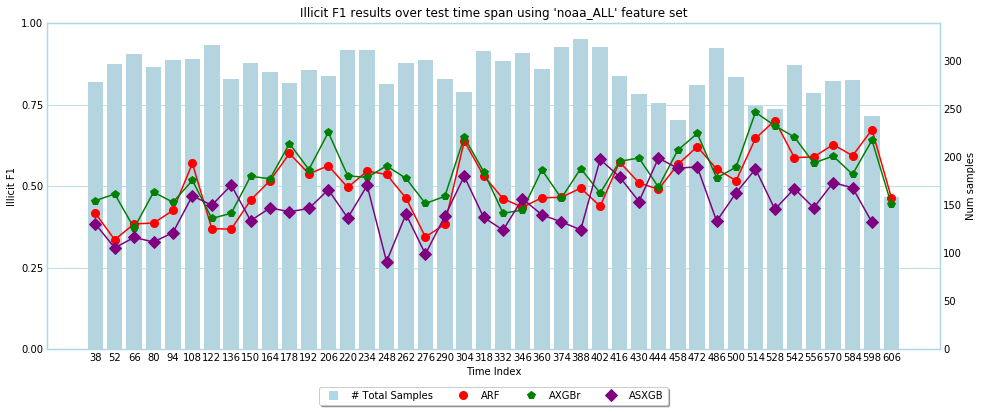

In [85]:

elliptic_time_indexed_results(test)
